# 作业：手写数字加法机

本文件是与集智AI学园出品的系列课程“火炬上的深度学习”配套的作业notebook。本作业要求学员构造一个卷积神经网，输入两张手写数字图片，输出这两个数字的和。

本文件提供了一个完成做的大框架，学员需要自行修改、添加代码，从而完成任务

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码


In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
USE_CUDA = torch.cuda.is_available()

In [3]:

# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 30  #训练的总循环周期
batch_size = 64

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个

sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler2
                                           )
#vlueerror: mutually exclussive with shuffle??

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

# MINST Adder

为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
因此，网络的架构为两个卷积神经网络，串联上两个全链接层

In [4]:
depth = [16, 32, 64]
fc = [1024, 256, 1] 
class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
        #公共网络部件
        self.net_pool = nn.MaxPool2d(kernel_size=2, stride=2) # only hyperparameter here
        self.bc1 = nn.BatchNorm1d(num_features=fc[0]) # batch normalization, because of the batch training
        self.bc2 = nn.BatchNorm1d(num_features=fc[1])
        
        #处理第一个图像处理用的卷积网络部件
        self.net1_conv1 = nn.Conv2d(in_channels=1, out_channels=depth[0], kernel_size=5, padding = 2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) 
        # feature map size is 7*7 by pooling
        self.net1_conv3 = nn.Conv2d(depth[1], depth[2], 5, padding = 2)
        # feature map size is 3*3 by pooling
         
        #处理第二个图像处理用的卷积网络部件
        self.net2_conv1 = nn.Conv2d(in_channels=1, out_channels=depth[0], kernel_size=5, padding = 2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) 
        # feature map size is 7*7 by pooling      
        self.net2_conv3 = nn.Conv2d(depth[1], depth[2], 5, padding = 2)
        # feature map size is 3*3 by pooling
        
        #后面的全连阶层
        self.fc1 = nn.Linear(in_features= 2 * depth[2] * (image_size // 4 // 2) * (image_size // 4 // 2), 
                             out_features=fc[0])
        self.fc2 = nn.Linear(fc[0], fc[1])
        self.fc3 = nn.Linear(fc[1], fc[2])
        
    def forward(self, x, y, training = True):
        #第一张图像的处理流程 
        x = F.relu(self.net1_conv1(x))         # 1*28*28 --> 16*28*28
        x = self.net_pool(x)                   # 16*28*28 --> 16*14*14
        x = F.relu(self.net1_conv2(x))         # 16*14*14 --> 32*14*14
        x = self.net_pool(x)                   # 32*14*14 --> 32*7*7
        x = F.relu(self.net1_conv3(x))         # 32*7*7 --> 64*7*7
        x = self.net_pool(x)                   # 64*7*7 --> 64*3*3
        x = x.view(-1, depth[2] * (image_size // 4 // 2) * (image_size // 4 // 2)) # flatten, reshape variable
         
        #第二张图像的处理流程
        y = F.relu(self.net2_conv1(y))         # 1*28*28 --> 16*28*28
        y = self.net_pool(y)                   # 16*28*28 --> 16*14*14
        y = F.relu(self.net2_conv2(y))         # 16*14*14 --> 32*14*14
        y = self.net_pool(y)                   # 32*14*14 --> 32*7*7
        y = F.relu(self.net2_conv3(y))         # 32*7*7 --> 64*7*7
        y = self.net_pool(y)                   # 64*7*7 --> 64*3*3
        y = y.view(-1, depth[2] * (image_size // 4 // 2) * (image_size // 4 // 2)) # flatten, reshape variable
         
        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        z = torch.cat((x, y), 1)                 
        z = F.relu(self.bc1(self.fc1(z)))       # 1024
        z = F.dropout(z, p=0.5, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = F.relu(self.bc2(self.fc2(z)))       # 1024 --> 256
        z = F.dropout(z, p=0.2, training=self.training)
        z = F.relu(self.fc3(z))                 # 256 --> 1    
        return z
        

# 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness(y, target):
    out = torch.round(y.view(-1)).type(torch.LongTensor)
    out = out.eq(target).sum()
    out1 = y.size()[0]
    return(out, out1)

net = MINSTAdder()
net

MINSTAdder (
  (net_pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (bc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (bc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (net1_conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (net1_conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (net1_conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (net2_conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (net2_conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (net2_conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear (1152 -> 1024)
  (fc2): Linear (1024 -> 256)
  (fc3): Linear (256 -> 1)
)

In [5]:
#将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平房误差作为我们的损失函数
if USE_CUDA:
    net.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001) #default learning rate = 0.001
results = {}

In [6]:
%%time
# 开始训练循环，本部分代码需要补齐
records = []
if USE_CUDA:
    for epoch in range(num_epochs):
        losses = []
        # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
        for idx, data in enumerate(zip(train_loader1, train_loader2)):
            ((x1, y1), (x2, y2)) = data
            optimizer.zero_grad()
            net.train()
            outputs = net(Variable(x1).cuda(), Variable(x2).cuda())
            labels = y1 + y2
            loss = criterion(outputs, Variable(labels.type(torch.FloatTensor)).cuda())
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])

            if idx % 100 == 0:
                net.eval()
                val_losses = []
                val_rights = []
                for v_idx, v_data in enumerate(zip(val_loader1, val_loader2)):
                    ((v_x1, v_y1), (v_x2, v_y2)) = v_data
                    v_outputs = net(Variable(v_x1).cuda(), Variable(v_x2).cuda()) 
                    v_labels = v_y1 + v_y2
                    v_loss = criterion(v_outputs, Variable(v_labels.type(torch.FloatTensor)).cuda())
                    val_losses.append(v_loss.data[0])
                    right = rightness(v_outputs, Variable(v_labels))
                    val_rights.append(right)



                val_r = (sum([tup[0].data[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))

                right_ratio = 100.0 * val_r[0] / val_r[1]

                #每间隔一定周期就打印一下训练集、校验集的准确率结果
                print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                    epoch, idx, len(train_loader1),
                    np.mean(losses), np.mean(val_losses), right_ratio))
                records.append([np.mean(losses), np.mean(val_losses), right_ratio])
else:
    for epoch in range(num_epochs):
        losses = []
        # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
        for idx, data in enumerate(zip(train_loader1, train_loader2)):
            ((x1, y1), (x2, y2)) = data
            optimizer.zero_grad()
            net.train()
            outputs = net(Variable(x1), Variable(x2))
            labels = y1 + y2
            loss = criterion(outputs, Variable(labels.type(torch.FloatTensor)))
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])

            if idx % 100 == 0:
                net.eval()
                val_losses = []
                val_rights = []
                for v_idx, v_data in enumerate(zip(val_loader1, val_loader2)):
                    ((v_x1, v_y1), (v_x2, v_y2)) = v_data
                    v_outputs = net(Variable(v_x1), Variable(v_x2)) 
                    v_labels = v_y1 + v_y2
                    v_loss = criterion(v_outputs, Variable(v_labels.type(torch.FloatTensor)))
                    val_losses.append(v_loss.data[0])
                    right = rightness(v_outputs, Variable(v_labels))
                    val_rights.append(right)



                val_r = (sum([tup[0].data[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))

                right_ratio = 100.0 * val_r[0] / val_r[1]

                #每间隔一定周期就打印一下训练集、校验集的准确率结果
                print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                    epoch, idx, len(train_loader1),
                    np.mean(losses), np.mean(val_losses), right_ratio))
                records.append([np.mean(losses), np.mean(val_losses), right_ratio])    
            


第0周期，第(0/938)个撮，训练误差：85.48, 校验误差：96.75, 准确率：0.90
第0周期，第(100/938)个撮，训练误差：45.34, 校验误差：16.21, 准确率：5.56
第0周期，第(200/938)个撮，训练误差：25.63, 校验误差：5.10, 准确率：24.12
第0周期，第(300/938)个撮，训练误差：18.09, 校验误差：4.05, 准确率：22.72
第0周期，第(400/938)个撮，训练误差：14.22, 校验误差：1.98, 准确率：36.76
第0周期，第(500/938)个撮，训练误差：11.82, 校验误差：2.49, 准确率：31.94
第0周期，第(600/938)个撮，训练误差：10.21, 校验误差：2.42, 准确率：34.86
第0周期，第(700/938)个撮，训练误差：9.04, 校验误差：1.37, 准确率：46.48
第0周期，第(800/938)个撮，训练误差：8.13, 校验误差：2.05, 准确率：41.98
第0周期，第(900/938)个撮，训练误差：7.42, 校验误差：1.35, 准确率：47.08
第1周期，第(0/938)个撮，训练误差：1.87, 校验误差：2.30, 准确率：35.16
第1周期，第(100/938)个撮，训练误差：1.60, 校验误差：1.15, 准确率：52.74
第1周期，第(200/938)个撮，训练误差：1.51, 校验误差：1.07, 准确率：55.38
第1周期，第(300/938)个撮，训练误差：1.48, 校验误差：1.55, 准确率：51.74
第1周期，第(400/938)个撮，训练误差：1.46, 校验误差：1.01, 准确率：58.06
第1周期，第(500/938)个撮，训练误差：1.43, 校验误差：0.92, 准确率：62.56
第1周期，第(600/938)个撮，训练误差：1.41, 校验误差：0.92, 准确率：62.98
第1周期，第(700/938)个撮，训练误差：1.39, 校验误差：1.05, 准确率：61.04
第1周期，第(800/938)个撮，训练误差：1.38, 校验误差：1.00, 准确率：55.20
第1周期，第(900/938)个撮，训练误差：1.37, 校验误差：0.97, 准确率：63.

第16周期，第(400/938)个撮，训练误差：0.36, 校验误差：0.35, 准确率：89.80
第16周期，第(500/938)个撮，训练误差：0.36, 校验误差：0.36, 准确率：89.20
第16周期，第(600/938)个撮，训练误差：0.37, 校验误差：0.34, 准确率：90.42
第16周期，第(700/938)个撮，训练误差：0.38, 校验误差：0.44, 准确率：85.22
第16周期，第(800/938)个撮，训练误差：0.38, 校验误差：0.37, 准确率：90.58
第16周期，第(900/938)个撮，训练误差：0.38, 校验误差：0.33, 准确率：91.10
第17周期，第(0/938)个撮，训练误差：0.31, 校验误差：0.35, 准确率：90.48
第17周期，第(100/938)个撮，训练误差：0.35, 校验误差：0.36, 准确率：90.20
第17周期，第(200/938)个撮，训练误差：0.38, 校验误差：0.37, 准确率：89.50
第17周期，第(300/938)个撮，训练误差：0.38, 校验误差：0.35, 准确率：88.38
第17周期，第(400/938)个撮，训练误差：0.37, 校验误差：0.33, 准确率：90.98
第17周期，第(500/938)个撮，训练误差：0.37, 校验误差：0.37, 准确率：90.78
第17周期，第(600/938)个撮，训练误差：0.38, 校验误差：0.35, 准确率：91.80
第17周期，第(700/938)个撮，训练误差：0.38, 校验误差：0.33, 准确率：91.20
第17周期，第(800/938)个撮，训练误差：0.38, 校验误差：0.34, 准确率：89.20
第17周期，第(900/938)个撮，训练误差：0.37, 校验误差：0.37, 准确率：89.68
第18周期，第(0/938)个撮，训练误差：0.36, 校验误差：0.42, 准确率：89.90
第18周期，第(100/938)个撮，训练误差：0.33, 校验误差：0.37, 准确率：90.56
第18周期，第(200/938)个撮，训练误差：0.35, 校验误差：0.34, 准确率：91.38
第18周期，第(300/938)个撮，训练误差：0.34, 校验误差：

/home/ken/anaconda3/envs/tf12/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type MINSTAdder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


在测试集上的准确率是：96.86%


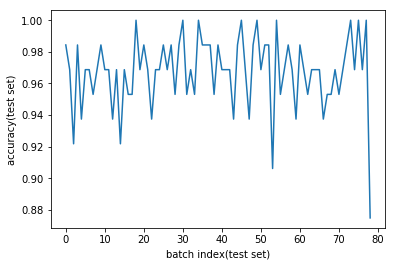

In [7]:
# save the parameters of net
torch.save(net, 'net_adder.pkl')
# 在测试集上运行我们的加法机网络，并测试预测准确度
net.eval()
if USE_CUDA:
    net.cpu()
    
vals = []
eval_rights = []

eval_samples_ind,  eval_samples_results = [], []
rand_indicies = np.arange(len(test_indices1) // batch_size)
np.random.shuffle(rand_indicies)
eval_samples_ind.extend(rand_indicies[:5])

for kdx, data_test in enumerate(zip(test_loader1, test_loader2)):
    ((xt1, yt1), (xt2, yt2)) = data_test
    xt1, xt2 = Variable(xt1), Variable(xt2)
    labelt = Variable(yt1+yt2)
    output_t = net(xt1, xt2)
    loss = criterion(output_t.type(torch.FloatTensor), labelt.type(torch.FloatTensor))
    right = rightness(output_t.data, labelt.data)
    vals.append(right)
    rr = right[0]
    aa = right[1]
    eval_rights.append(rr/float(aa))
    if kdx in eval_samples_ind:
        eval_samples_results.append((xt1.data.numpy(), xt2.data.numpy(), labelt.data.numpy(), 
                                     torch.round(output_t.data.view(-1)).numpy()))

val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 100.0 * val_r[0] / val_r[1]

print('在测试集上的准确率是：{:.2f}%'.format(right_rate))
    
plt.plot(np.arange(len(eval_rights)), eval_rights)
plt.xlabel('batch index(test set)')
plt.ylabel('accuracy(test set)')
plt.show()
            




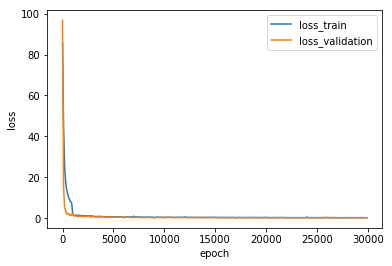

In [8]:
record_loss_train = [ _[0] for _ in records]
record_loss_val = [ _[1] for _ in records]
record_acc_val =[ _[2] for _ in records]

plt.plot(np.arange(len(records))*100, record_loss_train, label='loss_train')
plt.plot(np.arange(len(records))*100, record_loss_val, label='loss_validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

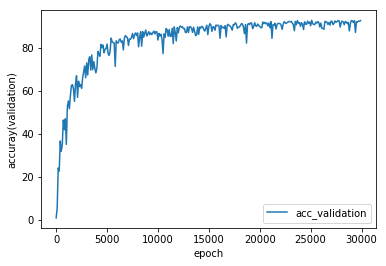

In [9]:
plt.plot(np.arange(len(records) )*100, record_acc_val, label='acc_validation')
plt.xlabel('epoch')
plt.ylabel('accuray(validation)')
plt.legend()
plt.show()

In [12]:
#evaluation and visulization on random samples
import random
def evaluate_randomly():
    ii = random.choice(eval_samples_results)
    pick = np.random.randint(batch_size)
    print('Input: ')
    fig = plt.figure(figsize=(5,5)) #!!!IMPORTANT!!! for many subplots
    print('Sum_true: ', int(ii[-2][pick]))
    print('Sum_pred: ', int(ii[-1][pick]))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(ii[j][pick,0,...])
    print('----------'*4)

Input: 
Sum_true:  13
Sum_pred:  13
----------------------------------------


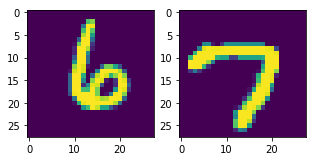

In [13]:
evaluate_randomly()

Input: 
Sum_true:  14
Sum_pred:  14
----------------------------------------


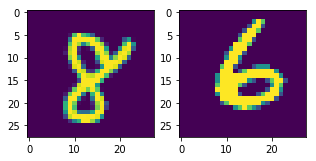

In [14]:
evaluate_randomly()

Input: 
Sum_true:  10
Sum_pred:  10
----------------------------------------


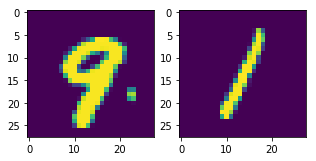

In [16]:
evaluate_randomly()

Input: 
Sum_true:  10
Sum_pred:  10
----------------------------------------


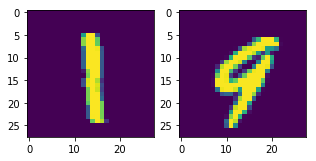

In [15]:
evaluate_randomly()

Input: 
Sum_true:  14
Sum_pred:  14
----------------------------------------


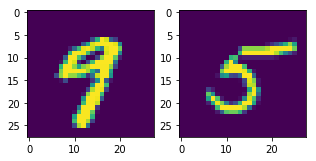

In [17]:
evaluate_randomly()